# DSC 232 – Group Project  
**Dataset:** NYC For-Hire Vehicle (FHV) – Uber, Lyft, Juno, Via


# Milestone 2 – Exploratory Data Analysis (EDA)

The primary goal of this milestone is to perform exploratory data analysis on the NYC FHV dataset.

For full project details, see the [GitHub README](https://github.com/RezaMoghadam/Group-Project-Data-NYC-FHV/blob/main/README.md).


This project analyzes NYC For-Hire Vehicle (FHV) data, covering ride records from 2019 to 2022.  
It includes services like Juno, Uber, Lyft, and Via. The compressed dataset is approximately 19 GB in size.

Due to its scale, we use the San Diego Supercomputer Center (SDSC) to process the data using Apache Spark.


## Requirements:
Execute the cell below to install all dependencies for this milestone:

In [ ]:
%pip install pyspark pandas matplotlib seaborn

### Dataset Description

This analysis uses the **NYC High Volume For-Hire Vehicle (HVFHV)** trip data, which includes detailed records of rides dispatched by major services such as Uber, Lyft, Via, and Juno from 2019 onward.

Each row represents a single trip and includes fields such as:

- `pickup_datetime` / `dropoff_datetime`: Timestamps for the ride
- `trip_miles`: Distance of the trip in miles
- `trip_time`: Duration of the ride in seconds
- `base_passenger_fare`: Fare before additional fees or tips
- `driver_pay`: Net pay received by the driver
- `tips`, `tolls`, `sales_tax`, `airport_fee`, etc.: Breakdown of monetary components
- `PULocationID`, `DOLocationID`: Pickup and drop-off taxi zone identifiers
- Flags for shared rides, wheelchair accessibility, and MTA involvement

For full details, refer to the official [NYC TLC Data Dictionary (PDF)](sandbox:/mnt/data/data_dictionary_trip_records_hvfhs.pdf).


### Dataset Download
The user has two options to download the dataset:
1. They can manually created a sub-directory called "Data" and copy the parquet files into that folder (located in teh same directory as the notebook)
2. They can use a Kaggle API call to download the dataset from within the notebook

The cell below will check if the "Data" directory exists where this notebook is located. If it does, we assume the user has manually downloaded the parquet files and put them in the directory. 

If "Data" directory does not exist, it runs lightweight setup script to create the directory and download the data. 

In [ ]:
# Setup & conditional install/download
import os
import sys
import subprocess
from pathlib import Path

# Where the data is expected to be downloaded for this notebook
data_dir = Path.cwd() / "Data"

if not data_dir.exists():
    # Install the Kaggle CLI into this same env
    subprocess.run(
        [sys.executable, "-m", "pip", "install", "--quiet", "kaggle"],
        check=True
    )

    # Create the Data/ directory
    data_dir.mkdir(parents=True, exist_ok=True)

    # Tell Kaggle CLI where to look for kaggle.json (in the notebook folder)
    os.environ['KAGGLE_CONFIG_DIR'] = str(Path.cwd()) # Change this if you want to use a different location

    # Verify kaggle.json is in place
    kaggle_json = Path(os.environ['KAGGLE_CONFIG_DIR']) / "kaggle.json"

    if not kaggle_json.exists():
        raise FileNotFoundError(
            f"Couldn't find kaggle.json at {kaggle_json}. Download it from your Kaggle account (API section) and place it there."
        )

    # Download & unzip into Data/
    subprocess.run(
        [
            "kaggle", "datasets", "download",
            "-d", "jeffsinsel/nyc-fhvhv-data",
            "-p", str(data_dir),
            "--unzip"
        ],
        check=True
    )
    print("Kaggle CLI installed, data downloaded into Data/ directory.")
else:
    print("Data directory already exists. Skipping install & download.")

The main step is to start the Spark Session and configure the available resources.

In [ ]:
from pyspark.sql import SparkSession

In [ ]:
sc = SparkSession.builder \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .config('spark.executor.instances', 5) \
    .config('spark.executor.cores', 2) \
    .getOrCreate()

Since the project files are in Parquet format, we use the appropriate app to read them. 

We load all Parquet files into a PySpark DataFrame (`df`) and examine the schema and first 20 rows to understand the structure.

In [ ]:
df = sc.read.parquet("Data/fhvhv_tripdata_*.parquet")


df.printSchema()
df.show(20)



root
 |-- hvfhs_license_num: string (nullable = true)
 |-- dispatching_base_num: string (nullable = true)
 |-- originating_base_num: string (nullable = true)
 |-- request_datetime: timestamp_ntz (nullable = true)
 |-- on_scene_datetime: timestamp_ntz (nullable = true)
 |-- pickup_datetime: timestamp_ntz (nullable = true)
 |-- dropoff_datetime: timestamp_ntz (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- trip_miles: double (nullable = true)
 |-- trip_time: long (nullable = true)
 |-- base_passenger_fare: double (nullable = true)
 |-- tolls: double (nullable = true)
 |-- bcf: double (nullable = true)
 |-- sales_tax: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- airport_fee: integer (nullable = true)
 |-- tips: double (nullable = true)
 |-- driver_pay: double (nullable = true)
 |-- shared_request_flag: string (nullable = true)
 |-- shared_match_flag: string (nullable = true)
 |-- access_a_ride_

We check the total number of records in the dataset.

In [ ]:
df.count()

745287023

We list all available columns in the DataFrame.

In [ ]:
df.columns



['hvfhs_license_num',
 'dispatching_base_num',
 'originating_base_num',
 'request_datetime',
 'on_scene_datetime',
 'pickup_datetime',
 'dropoff_datetime',
 'PULocationID',
 'DOLocationID',
 'trip_miles',
 'trip_time',
 'base_passenger_fare',
 'tolls',
 'bcf',
 'sales_tax',
 'congestion_surcharge',
 'airport_fee',
 'tips',
 'driver_pay',
 'shared_request_flag',
 'shared_match_flag',
 'access_a_ride_flag',
 'wav_request_flag',
 'wav_match_flag']

# Data Cleaning

Some columns are not relevant to our analysis goals. We drop those unnecessary columns in the following step.

In [8]:

df = df.drop(*[col for col in df.columns if col.endswith("_flag")])


In [9]:
df.show()

+-----------------+--------------------+--------------------+-------------------+-------------------+-------------------+-------------------+------------+------------+----------+---------+-------------------+-----+----+---------+--------------------+-----------+----+----------+
|hvfhs_license_num|dispatching_base_num|originating_base_num|   request_datetime|  on_scene_datetime|    pickup_datetime|   dropoff_datetime|PULocationID|DOLocationID|trip_miles|trip_time|base_passenger_fare|tolls| bcf|sales_tax|congestion_surcharge|airport_fee|tips|driver_pay|
+-----------------+--------------------+--------------------+-------------------+-------------------+-------------------+-------------------+------------+------------+----------+---------+-------------------+-----+----+---------+--------------------+-----------+----+----------+
|           HV0003|              B02867|              B02867|2019-02-01 00:01:26|2019-02-01 00:02:55|2019-02-01 00:05:18|2019-02-01 00:14:57|         245|         

We select the key features needed for analysis and drop rows containing null values.

In [10]:
important_cols = [
    "pickup_datetime", "dropoff_datetime", "trip_miles", "trip_time",
    "base_passenger_fare", "driver_pay", "PULocationID", "DOLocationID"
]

df = df.dropna(subset=important_cols)


We remove ride records with zero miles or zero fare, as they are likely invalid.

In [11]:
df = df.filter(
    "trip_miles > 0 AND trip_time > 0 AND base_passenger_fare >= 0 AND driver_pay >= 0"
)


We identify and remove outliers to ensure more reliable analysis.

In [12]:
df = df.filter("trip_miles < 100 AND trip_time < 7200 AND driver_pay < 500")


We count the remaining records to assess how many were removed.  
Approximately 2 million rows were dropped, which is relatively small compared to the total dataset size and should not affect overall model performance.

In [13]:
df.count()

743008421

The first plot shows the distribution of rides by hour of the day.

In [14]:
from pyspark.sql.functions import hour

df_by_hour = df.withColumn("hour", hour("pickup_datetime"))


In [15]:
hourly_counts = df_by_hour.groupBy("hour").count().orderBy("hour")


In [16]:
pdf = hourly_counts.toPandas()


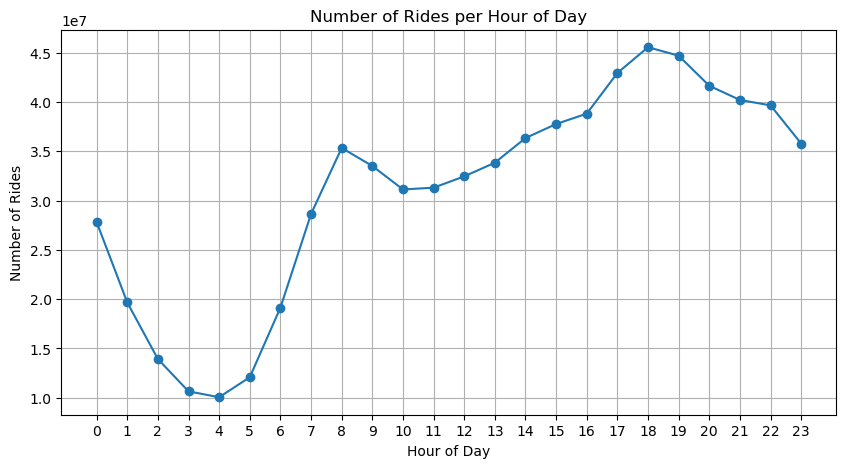

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(pdf["hour"], pdf["count"], marker='o')
plt.title("Number of Rides per Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Rides")
plt.grid(True)
plt.xticks(range(0, 24))
plt.show()


As observed in the plot, 5–7 PM represents the peak demand period for for-hire vehicle rides.

The following plot examines ride volume by hour and day of the week.

In [18]:
from pyspark.sql.functions import date_format

df_hour_day = df.withColumn("hour", hour("pickup_datetime")) \
                .withColumn("weekday", date_format("pickup_datetime", "E"))  


In [19]:
rides_by_hour_day = df_hour_day.groupBy("weekday", "hour").count()


In [20]:
pdf = rides_by_hour_day.toPandas()


from pandas.api.types import CategoricalDtype

weekday_order = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
pdf["weekday"] = pdf["weekday"].astype(CategoricalDtype(categories=weekday_order, ordered=True))
pdf = pdf.sort_values(["weekday", "hour"])


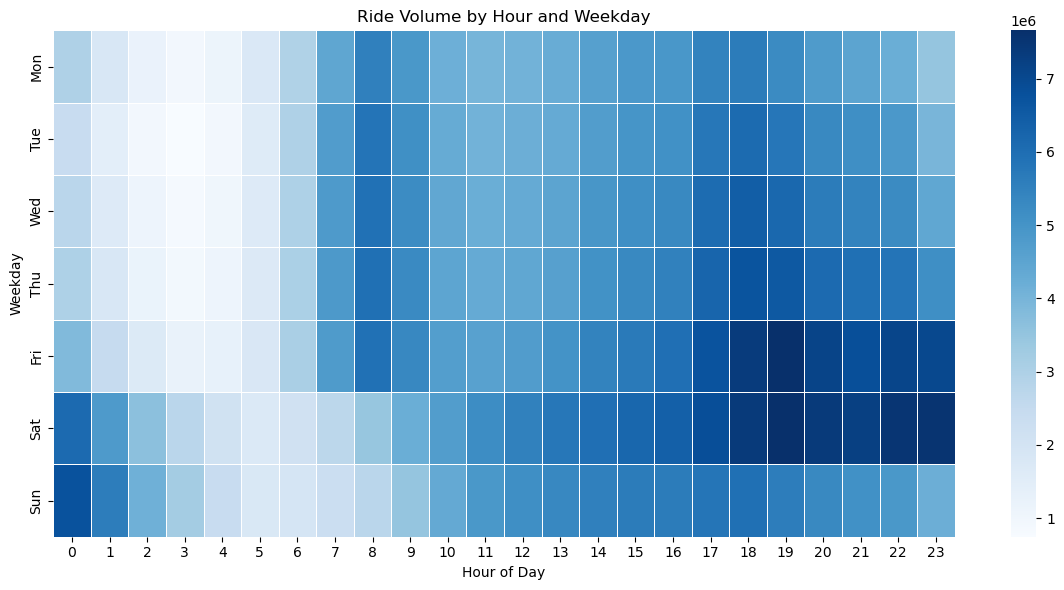

In [21]:
import seaborn as sns
import pandas as pd

# Pivot table for heatmap
heatmap_data = pdf.pivot(index="weekday", columns="hour", values="count")

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap="Blues", linewidths=0.5, annot=False)
plt.title("Ride Volume by Hour and Weekday")
plt.xlabel("Hour of Day")
plt.ylabel("Weekday")
plt.tight_layout()
plt.show()


The results indicate higher activity during weekend nights and Sunday mornings.  
Sunday evenings show a decline, likely as the city winds down before the start of the workweek.

The next plot compares average trip distance and fare across different hours of the day.

In [22]:
df_with_hour = df.withColumn("hour", hour("pickup_datetime"))


In [23]:
avg_miles = df_with_hour.groupBy("hour").avg("trip_miles").orderBy("hour")


In [24]:
avg_fare = df_with_hour.groupBy("hour").avg("base_passenger_fare").orderBy("hour")


In [25]:
avg_metrics = df_with_hour.groupBy("hour").agg(
    {"trip_miles": "avg", "base_passenger_fare": "avg"}
).orderBy("hour")


In [26]:
pdf = avg_metrics.toPandas()
pdf.columns = ["hour", "avg_trip_miles", "avg_base_fare"]


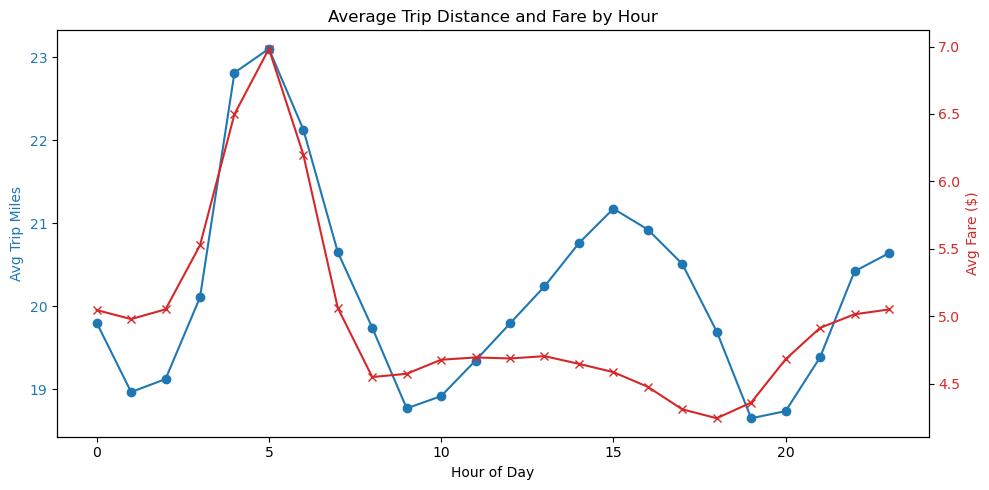

In [27]:

fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.set_xlabel("Hour of Day")
ax1.set_ylabel("Avg Trip Miles", color="tab:blue")
ax1.plot(pdf["hour"], pdf["avg_trip_miles"], color="tab:blue", marker="o", label="Avg Miles")
ax1.tick_params(axis='y', labelcolor="tab:blue")

ax2 = ax1.twinx()
ax2.set_ylabel("Avg Fare ($)", color="tab:red")
ax2.plot(pdf["hour"], pdf["avg_base_fare"], color="tab:red", marker="x", label="Avg Fare")
ax2.tick_params(axis='y', labelcolor="tab:red")

plt.title("Average Trip Distance and Fare by Hour")
fig.tight_layout()
plt.show()


Driving between 12 PM and 7 PM appears to yield lower fare-per-mile ratios, suggesting this may be a less profitable period for drivers.

This plot explores the relationship between trip distance and tip amount.

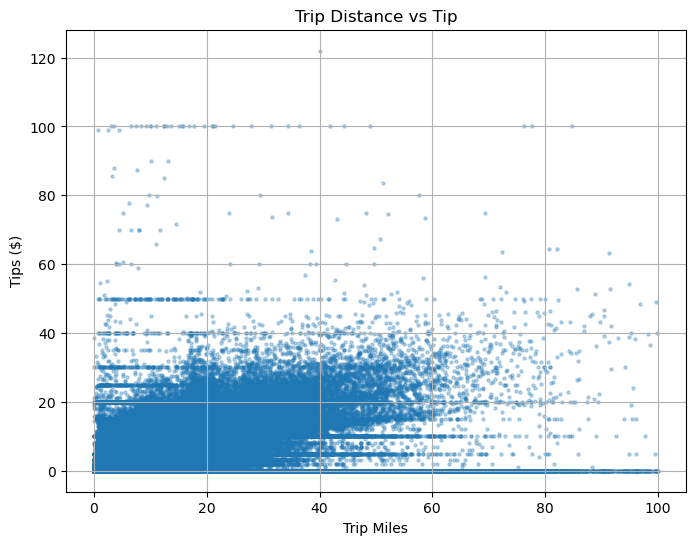

In [28]:
sample_df = df.select("trip_miles", "tips").dropna().limit(10000000)
pdf = sample_df.toPandas()

plt.figure(figsize=(8, 6))
plt.scatter(pdf["trip_miles"], pdf["tips"], alpha=0.3, s=5)
plt.xlabel("Trip Miles")
plt.ylabel("Tips ($)")
plt.title("Trip Distance vs Tip")
plt.grid(True)
plt.show()


A positive correlation is observed, although tips do not increase proportionally with distance.

The next two plots are to view the relation between the Driver Pay and two main variables, Trip Duration and Trip Distance.

In [ ]:
sample_df = df.select("trip_time", "driver_pay") \
              .dropna() \
              .filter("trip_time > 0 AND driver_pay > 0") \
              .limit(10000000)

pdf = sample_df.toPandas()


In [30]:
pdf["trip_time_minutes"] = pdf["trip_time"] / 60


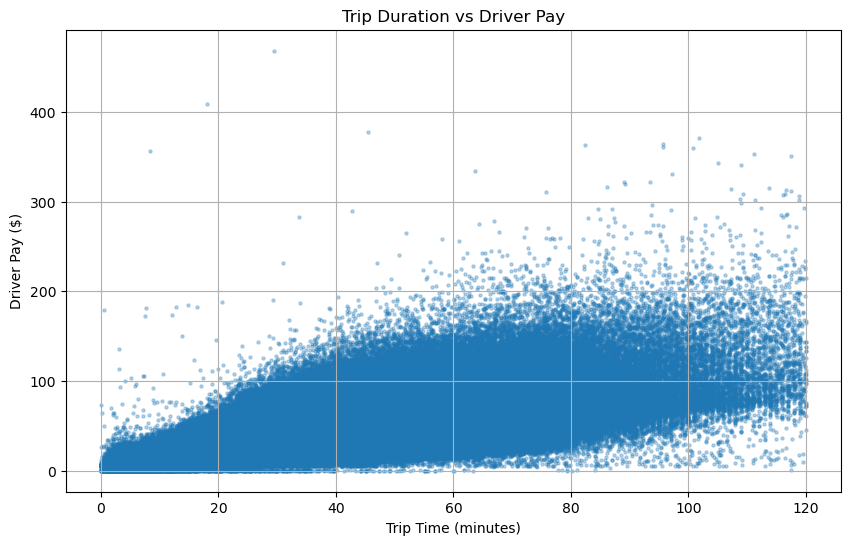

In [31]:


plt.figure(figsize=(10, 6))
plt.scatter(pdf["trip_time_minutes"], pdf["driver_pay"], alpha=0.3, s=5)
plt.xlabel("Trip Time (minutes)")
plt.ylabel("Driver Pay ($)")
plt.title("Trip Duration vs Driver Pay")
plt.grid(True)
plt.show()


### Trip Duration vs. Driver Pay

This plot illustrates the relationship between trip duration and driver pay.

As expected, longer trip durations generally correspond to higher driver earnings.  
However, the relationship may not be strictly linear due to factors such as traffic, minimum fare policies, and waiting time charges.


In [32]:
sample_df = df.select("trip_miles", "driver_pay") \
              .dropna() \
              .filter("trip_miles > 0 AND driver_pay > 0") \
              .limit(10000000)

pdf = sample_df.toPandas()


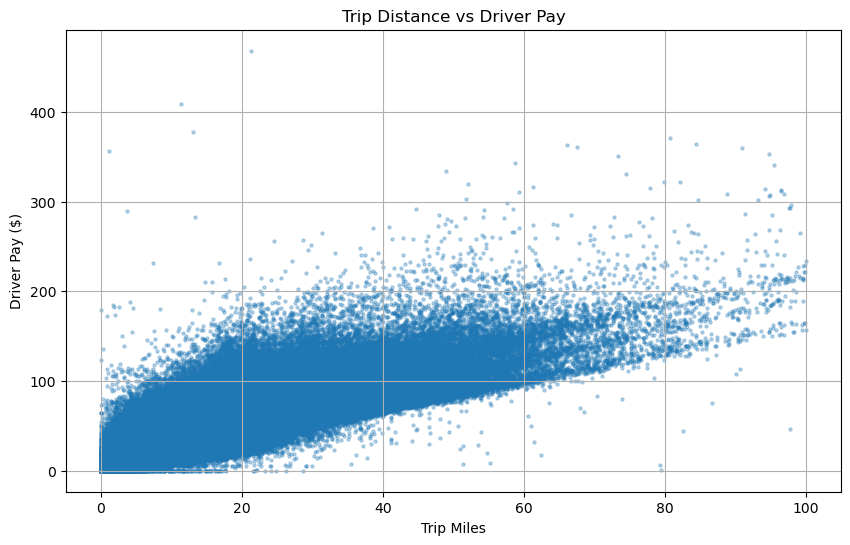

In [33]:
plt.figure(figsize=(10, 6))
plt.scatter(pdf["trip_miles"], pdf["driver_pay"], alpha=0.3, s=5)
plt.xlabel("Trip Miles")
plt.ylabel("Driver Pay ($)")
plt.title("Trip Distance vs Driver Pay")
plt.grid(True)
plt.show()


### Trip Distance vs. Driver Pay

This plot illustrates the relationship between trip distance (in miles) and driver pay.

Driver earnings increase with distance, reflecting the fare structure based on mileage.  
The spread of data points also indicates variability, suggesting other factors like time of day, traffic, and surge pricing may influence pay beyond just distance.

